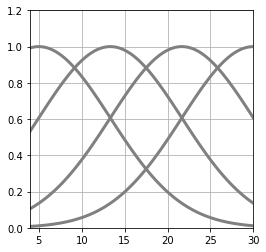

In [10]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

outfile = np.load('ch_data.npz')
X = outfile['X']
X_min = outfile['X_min']
X_max = outfile['X_max']
X_n = outfile['X_n']
T = outfile['T']

def gauss(x, mu, s):
    return np.exp(-(x-mu)**2 / (2*s**2))
    
M = 4
plt.figure(figsize=(4,4))
mu = np.linspace(5,30,M)
s = mu[1] - mu[0]
xb = np.linspace(X_min, X_max, 100)
for j in range(M):
    y = gauss(xb,mu[j],s)
    plt.plot(xb,y,color='gray',linewidth=3)
plt.grid(True)
plt.xlim(X_min,X_max)
plt.ylim(0,1.2)
plt.show()

W=[29.4 75.7  2.9 98.3 54.9]
SD =3.98 cm


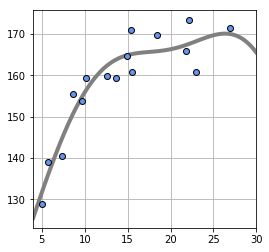

In [34]:
def gauss_func(w,x):
    m = len(w) - 1
    mu = np.linspace(5,30,m)
    s = mu[1] - mu[0]
    y = np.zeros_like(x)
    for j in range(m):
        y = y + w[j] * gauss(x,mu[j],s)
        
    y = y + w[m]
    return y

def mse_gauss_func(x,t,w):
    y = gauss_func(w,x)
    mse = np.mean((y-t)**2)
    return mse

def fit_gauss_func(x,t,m):
    mu = np.linspace(5,30,m)
    s = mu[1] - mu[0]
    n = x.shape[0]
    psi = np.ones((n, m+1))
    for j in range(m):
        psi[:,j] = gauss(x,mu[j],s)
    psi_T = np.transpose(psi)
    
    b = np.linalg.inv(psi_T.dot(psi))
    c = b.dot(psi_T)
    w = c.dot(t)
    return w

def show_gauss_func(w):
    xb = np.linspace(X_min, X_max, 100)
    y = gauss_func(w, xb)
    plt.plot(xb, y, c=[.5,.5,.5],lw=4)
    
plt.figure(figsize=(4,4))
M=4
W = fit_gauss_func(X,T,M)
show_gauss_func(W)
plt.plot(X,T,marker='o',linestyle='None',color='cornflowerblue',markeredgecolor='black')
plt.xlim(X_min,X_max)
plt.grid(True)
mse = mse_gauss_func(X,T,W)
print('W=' + str(np.round(W,1)))
print("SD ={0:.2f} cm".format(np.sqrt(mse)))
plt.show()

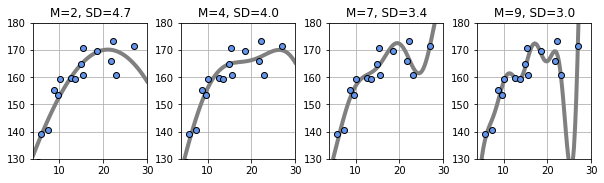

In [3]:
# オーバーフィッティングの問題
plt.figure(figsize=(10,2.5))
plt.subplots_adjust(wspace=0.3)
M = [2,4,7,9]
for i in range(len(M)):
    plt.subplot(1, len(M), i+1)
    W = fit_gauss_func(X,T,M[i])
    show_gauss_func(W)
    plt.plot(X, T, marker='o', linestyle='None', color='cornflowerblue', markeredgecolor='black')
    plt.xlim(X_min,X_max)
    plt.grid(True)
    plt.ylim(130,180)
    mse = mse_gauss_func(X,T,W)
    
    plt.title("M={0:d}, SD={1:.1f}".format(M[i], np.sqrt(mse)))

plt.show()

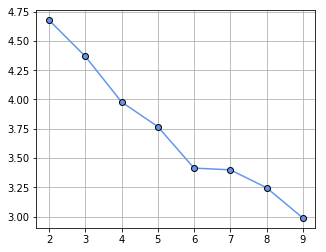

In [5]:
plt.figure(figsize=(5,4))
M = range(2,10)
mse2 = np.zeros(len(M))
for i in range(len(M)):
    W = fit_gauss_func(X,T,M[i])
    mse2[i] = np.sqrt(mse_gauss_func(X,T,W))
plt.plot(M, mse2, marker='o', color='cornflowerblue', markeredgecolor='black')
plt.grid(True)
plt.show()

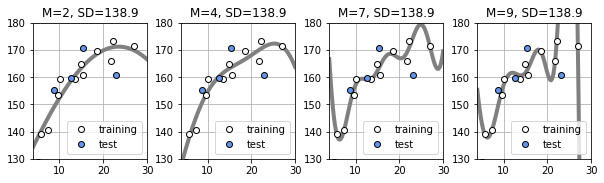

In [20]:
# 訓練データとテストデータ
X_test = X[:int(X_n / 4 + 1)]
T_test = T[:int(X_n / 4 + 1)]
X_train = X[int(X_n / 4 + 1):]
T_train = T[int(X_n / 4 + 1):]

plt.figure(figsize=(10,2.5))

plt.subplots_adjust(wspace=0.3)

M=[2,4,7,9]
for i in range(len(M)):
    plt.subplot(1, len(M), i+1)
    W = fit_gauss_func(X_train, T_train, M[i])
    show_gauss_func(W)
    plt.plot(X_train, T_train, marker='o',
             linestyle='None', color='white',
             markeredgecolor='black', label='training')
    plt.plot(X_test, T_test, linestyle='None', marker='o',
             color='cornflowerblue',markeredgecolor='black', label='test')
    plt.legend(loc='lower right', fontsize=10,numpoints=1)
    plt.xlim(X_min,X_max)
    plt.ylim(130,180)
    plt.grid(True)
    mse = mse_gauss_func(X_test,T_test,M)
    plt.title("M={0:d}, SD={1:.1f}".format(M[i], np.sqrt(mse)))
plt.show()


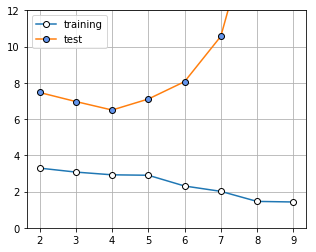

In [27]:
plt.figure(figsize=(5,4))

M = range(2,10)

mse_train = np.zeros(len(M))
mse_test = np.zeros(len(M))

for i in range(len(M)):
    W = fit_gauss_func(X_train, T_train, M[i])
    mse_train[i] = np.sqrt(mse_gauss_func(X_train, T_train, W))
    mse_test[i] = np.sqrt(mse_gauss_func(X_test, T_test, W))

plt.plot(M, mse_train, marker='o', linestyle='-',
         markerfacecolor='white', markeredgecolor='black', label='training')
plt.plot(M, mse_test, marker='o', linestyle='-',
         markerfacecolor='cornflowerblue', markeredgecolor='black', label='test')
plt.legend(loc='upper left', fontsize=10)
plt.ylim(0,12)
plt.grid(True)
plt.show()

In [36]:
# K分割交差検証
def kfold_gauss_func(x, t, m, k):
    n = x.shape[0]
    mse_train = np.zeros(k)
    mse_test = np.zeros(k)
    for i in range(0,k):
        x_train = x[np.fmod(range(n), k) != i]
        t_train = t[np.fmod(range(n), k) != i]
        x_test = x[np.fmod(range(n), k) == i]
        t_test = t[np.fmod(range(n), k) == i]

        wm = fit_gauss_func(x_train, t_train, m)
        
        mse_train[i] = mse_gauss_func(x_train, t_train, wm)
        mse_test[i] = mse_gauss_func(x_test, t_test, wm)
    return mse_train,mse_test

In [30]:
np.fmod(range(10),5)

array([0, 1, 2, 3, 4, 0, 1, 2, 3, 4])

In [37]:
M = 4
K = 4
kfold_gauss_func(X, T, M, K)

(array([12.87927851,  9.81768697, 17.2615696 , 12.92270498]),
 array([ 39.65348229, 734.70782012,  18.30921743,  47.52459642]))

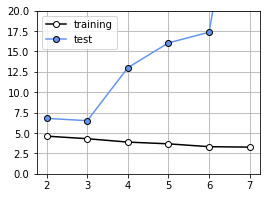

In [38]:
M = range(2,8)

K = 16

Cv_Gauss_train = np.zeros((K, len(M)))
Cv_Gauss_test = np.zeros((K, len(M)))
for i in range(0, len(M)):
    Cv_Gauss_train[:,i],Cv_Gauss_test[:,i] = kfold_gauss_func(X,T,M[i],K)
    
mean_Gauss_train = np.sqrt(np.mean(Cv_Gauss_train, axis=0))
mean_Gauss_test = np.sqrt(np.mean(Cv_Gauss_test, axis=0))

plt.figure(figsize=(4,3))
plt.plot(M, mean_Gauss_train, marker='o', linestyle='-',
         color='k', markerfacecolor='w', label='training')
plt.plot(M, mean_Gauss_test, marker='o', linestyle='-',
         color='cornflowerblue',markeredgecolor='black',label='test')
plt.legend(loc='upper left', fontsize=10)
plt.ylim(0,20)
plt.grid(True)
plt.show()

                          

SD=4.37 cm


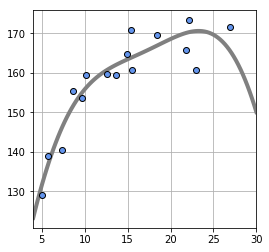

In [40]:
M = 3
plt.figure(figsize=(4,4))
W = fit_gauss_func(X,T,M)
show_gauss_func(W)
plt.plot(X,T,marker='o',linestyle='None',
         color='cornflowerblue',markeredgecolor='black')
plt.xlim([X_min, X_max])
plt.grid(True)
mse = mse_gauss_func(X,T,W)
print("SD={0:.2f} cm".format(np.sqrt(mse)))
plt.show()

w0 = 169.0,w1=113.7,w2=0.2
SD=3.86 cm


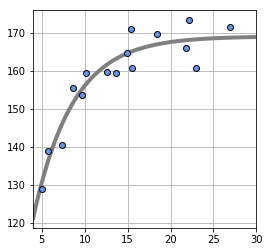

In [44]:
def model_A(x,w):
    y = w[0] - w[1] * np.exp(-w[2] * x)
    return y

def show_model_A(w):
    xb = np.linspace(X_min,X_max,100)
    y = model_A(xb,w)
    plt.plot(xb, y, c =[.5,.5,.5], lw=4)
    
def mse_model_A(w,x,t):
    y = model_A(x,w)
    mse = np.mean((y-t)**2)
    return mse

from scipy.optimize import minimize

def fit_model_A(w_init, x, t):
    res1 = minimize(mse_model_A, w_init,args=(x,t), method="powell")
    return res1.x

plt.figure(figsize=(4,4))
W_init = [100,0,0]
W = fit_model_A(W_init,X,T)
print("w0 = {0:.1f},w1={1:.1f},w2={2:.1f}".format(W[0],W[1],W[2]))

show_model_A(W)
plt.plot(X,T,marker='o',linestyle='None',
         color='cornflowerblue', markeredgecolor='black')
plt.xlim(X_min,X_max)
plt.grid(True)
mse = mse_model_A(W,X,T)
print("SD={0:.2f} cm".format((np.sqrt(mse))))
plt.show()

Gauss(M=3) SD=6.51 cm
Model A SD=3.88 cm


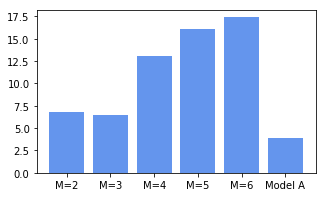

In [45]:
def kfold_model_A(x, t, k):
    n = len(x)
    mse_train = np.zeros(k)
    mse_test = np.zeros(k)
    for i in range(0,k):
        x_train = x[np.fmod(range(n), k) != i]
        t_train = t[np.fmod(range(n), k) != i]
        x_test = x[np.fmod(range(n), k) == i]
        t_test = t[np.fmod(range(n), k) == i]
        wm = fit_model_A(np.array([169,113,0.2]), x_train, t_test)
        mse_train[i] = mse_model_A(wm, x_train, t_train)
        mse_test[i] = mse_model_A(wm, x_test, t_test)
    return mse_train, mse_test

K = 16
Cv_A_train, Cv_A_test = kfold_model_A(X,T,K)
mean_A_test = np.sqrt(np.mean(Cv_Gauss_train))
print("Gauss(M=3) SD={0:.2f} cm".format(mean_Gauss_test[1]))
print("Model A SD={0:.2f} cm".format(mean_A_test))
SD = np.append(mean_Gauss_test[0:5],  mean_A_test)
M=range(6)
label = ["M=2","M=3","M=4","M=5","M=6", "Model A"]
plt.figure(figsize=(5,3))
plt.bar(M, SD, tick_label=label, align="center", facecolor="cornflowerblue")
plt.show()
                      

        